In [1]:
# Imports

from OverwatchProcessData import get_competitive_rank, get_vector_gamestats, get_vector_herostats, general_stats
from OverwatchGatherData import Player, find_usernames

from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout

import matplotlib.pyplot as plt

import numpy as np
import os

np.random.seed(5)

Using TensorFlow backend.


In [2]:
# Load Data

general_general_stats = ["kpd"]

for stat in general_stats:

    if "avg" in stat:

        general_general_stats.append(stat)

def load_data():

    unscaled_X, unscaled_y = [], []

    for filename in os.listdir('profiles'):

        player = Player.from_file(os.path.join('profiles', filename))

        rank = get_competitive_rank(player, 'us')

        if rank: # Only use data w/rank attached

            unscaled_X.append(get_vector_gamestats(player, 'us', 'competitive'))
            unscaled_y.append(rank)

    unscaled_X = np.array(unscaled_X, dtype=np.float64)
    unscaled_y = np.array(unscaled_y, dtype=np.float64)
    
    return unscaled_X, unscaled_y

def load_data2():

    unscaled_X, unscaled_y = [], []

    for filename in os.listdir('profiles'):

        player = Player.from_file(os.path.join('profiles', filename))

        rank = get_competitive_rank(player, 'us')

        if rank:

            unscaled_X.append(get_vector_gamestats(player, 'us', 'competitive', stat_keys=general_general_stats))
            unscaled_y.append(rank)

    unscaled_X = np.array(unscaled_X, dtype=np.float64)
    unscaled_y = np.array(unscaled_y, dtype=np.float64)
    
    return unscaled_X, unscaled_y

def load_data3():

    unscaled_X, unscaled_y = [], []

    for filename in os.listdir('profiles'):

        player = Player.from_file(os.path.join('profiles', filename))

        rank = get_competitive_rank(player, 'us')

        if rank:

            unscaled_X.append(get_vector_herostats(player, 'us', 'competitive'))
            unscaled_y.append(rank)

    unscaled_X = np.array(unscaled_X, dtype=np.float64)
    unscaled_y = np.array(unscaled_y, dtype=np.float64)
    
    return unscaled_X, unscaled_y


In [3]:
# Standardize Data

def scale_data(unscaled_X, unscaled_y):
    
    scaler_X = StandardScaler()
    scaler_y = StandardScaler(with_mean=False) # SR is 1-5000 so scaling w/mean has weird effects

    X = scaler_X.fit_transform(unscaled_X)
    y = np.squeeze(scaler_y.fit_transform(unscaled_y.reshape(-1, 1)))
    
    return X, y, scaler_X, scaler_y

def scale_data2(unscaled_X, unscaled_y):
    
    scaler_X = StandardScaler()

    X = scaler_X.fit_transform(unscaled_X)
    y = unscaled_y
    
    return X, y, scaler_X


In [4]:
# Keras Model

def get_model():

    model = Sequential()
    model.add(Dense(50, input_dim=68, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(40, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(30, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))

    model.compile(loss='mean_squared_error', optimizer='adam') # MSE loss b/c regression
    
    return model

def get_model2():

    model = Sequential()
    model.add(Dense(12, input_dim=13, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(20, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(50, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))

    model.compile(loss='mean_squared_error', optimizer='adam')
    
    return model

def get_model3():

    model = Sequential()
    model.add(Dense(1000, input_dim=3090, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(200, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(200, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))

    model.compile(loss='mean_squared_error', optimizer='adam')
    
    return model


In [5]:
# Learning function. Wrapper for keras model.fit( ... )

def fit_to_data(model, *args, **kwargs):

    history = model.fit(*args, **kwargs, shuffle=True, verbose=0)
    
    return history


In [6]:
# Predict SR

def predict_sr(model, player):
    
    stats_vector = np.array([get_vector_gamestats(player, 'us', 'competitive')])
    
    X = scaler_X.transform(stats_vector)

    y_matrix = model.predict(X)
    
    sr = np.squeeze(scaler_y.inverse_transform(y_matrix))
    
    return int(sr)

def predict_sr2(model, player):
    
    stats_vector = np.array([get_vector_gamestats(player, 'us', 'competitive', stat_keys=general_general_stats)])
    
    X = scaler_X2.transform(stats_vector)

    y_matrix = model.predict(X)
    
    sr = np.squeeze(y_matrix)
    
    return int(sr)

def predict_sr3(model, player):
    
    stats_vector = np.array([get_vector_herostats(player, 'us', 'competitive')])
    
    X = scaler_X3.transform(stats_vector)

    y_matrix = model.predict(X)
    
    sr = np.squeeze(y_matrix)
    
    return int(sr)


In [7]:
# Stats

def view(history):
    
    plt.plot(np.log(history.history['loss']))
    plt.plot(np.log(history.history['val_loss']))
    plt.title('Model Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Test'], loc='upper right')
    plt.show()
    

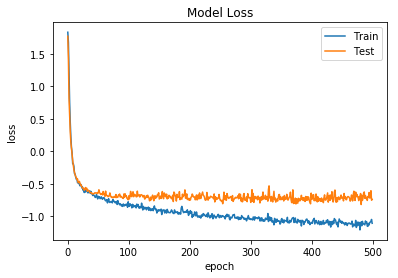

In [8]:
# Model 1

X, y, scaler_X, scaler_y = scale_data(*load_data())

model = get_model()

history = fit_to_data(model, X, y, epochs=500, batch_size=128, validation_split=.10)

model.save('overwatch-sr-1.h5')

view(history)

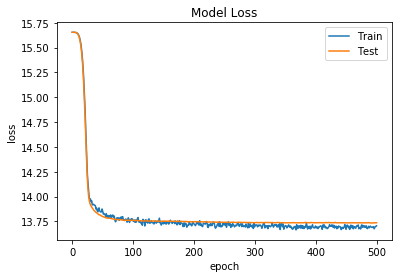

In [9]:
# Model 2

X2, y2, scaler_X2 = scale_data2(*load_data2())

model2 = get_model2()

history2 = fit_to_data(model2, X2, y2, epochs=500, batch_size=128, validation_split=.10)

model2.save('overwatch-sr-2.h5')

view(history2)

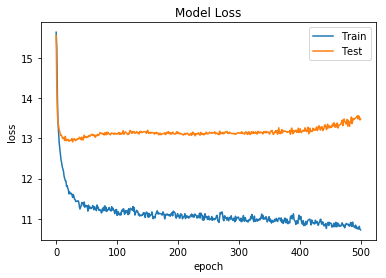

In [10]:
# Model 3

X3, y3, scaler_X3 = scale_data2(*load_data3())

model3 = get_model3()

history3 = fit_to_data(model3, X3, y3, epochs=500, batch_size=128, validation_split=.10)

model3.save('overwatch-sr-3.h5')

view(history3)

In [ ]:

with open('test_names.txt', 'r') as test:

    for battletag in find_usernames(test.read()):
        
        player = Player.from_web_battletag(battletag)
        
        actual = get_competitive_rank(player, 'us')
        p1 = predict_sr(model, player)
        p2 = predict_sr2(model2, player)
        p3 = predict_sr3(model3, player)
        
        print("{} is {}, predicted {}, {}, {}".format(battletag, actual, p1, p2, p3))
